Install necessary libraries `scipy` for scientific computing, `seaborn` for data visualization capabilities, and `optuna` for hyperparameter tuning.


In [ ]:
# Install Required Libraries
!pip install scipy seaborn optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


"Mount Google Drive to access the data

In [ ]:
# Mount Google Drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the required libraries. `numpy` for numerical operations, `scipy.io` for loading MATLAB files, `sklearn` for machine learning model creation, training, and evaluation, `matplotlib.pyplot` and `seaborn` for data visualization, and `optuna` for hyperparameter tuning


In [ ]:
# Import necessary libraries
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

Load the coherence data from a MATLAB (.mat) file stored in Google Drive. It contains the coherence matrices for Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD), and Healthy Controls (HC). Use `scipy.io.loadmat` to read the .mat file


In [ ]:
# Load the coherence data from .mat file
mat_file_path = '/content/drive/MyDrive/GNN_Approach/Data_files/Coherence.mat'
mat = scipy.io.loadmat(mat_file_path)
coherence_data = mat['Coherence'][0, 0]

Extract the Coherence data for different categories: Alzheimer's Disease (AZ), Frontotemporal Dementia (FTD)

In [ ]:
# Extracting data in different categories (AZ, FTD, HC)
coherence_AZ_F = coherence_data['AZ']
coherence_FTD_F = coherence_data['FTD']

Extract the data corresponding to the 3rd frequency band (index 2) and then reshape the extracted data

In [ ]:
# Extract the 3rd frequency band (index 2) and normalize the data
coherence_AZ = coherence_AZ_F[:, 2, :].reshape(2346, 1, 36)
coherence_FTD = coherence_FTD_F[:, 2, :].reshape(2346, 1, 23)

# Optional: To test whether the data is converted properly into numpy arrays
print(coherence_AZ.shape)
print(coherence_FTD.shape)

(2346, 1, 36)
(2346, 1, 23)


Reconstructs the coherence matrix from the extracted coherence data. The function iterates over frequency bands and subjects, creating a 68x68 matrix with coherence values. The rebuilt matrices are stored in a 4D array with dimensions corresponding to regions, regions, bands, and subjects

In [ ]:
# Function to rebuild the coherence matrix from the coherence data
def rebuild_matrix(coherence_data):
    n_regions = 68
    n_data = coherence_data.shape[2]
    n_bands = coherence_data.shape[1]

    rebuilt_data = np.zeros((n_regions, n_regions, n_bands, n_data))

    for band in range(n_bands):
        for subject in range(n_data):
            matrix = np.zeros((n_regions, n_regions))
            idx = 0
            for col in range(n_regions):
                for row in range(col + 1):
                    matrix[row, col] = coherence_data[idx, band, subject]
                    idx += 1
            matrix = matrix + matrix.T - np.diag(matrix.diagonal())
            rebuilt_data[:, :, band, subject] = matrix

    return rebuilt_data

Reconstruct the coherence matrices for each category (AZ, FTD) and check the shapes of the resulting matrices to ensure that they have been reconstructed correctly and have the expected dimensions

In [ ]:
# Rebuild the coherence matrices
coherence_AZ_rebuilt = rebuild_matrix(coherence_AZ)
coherence_FTD_rebuilt = rebuild_matrix(coherence_FTD)

# Check the shapes to ensure correctness
print('PLV_AZ_rebuilt shape:', coherence_AZ_rebuilt.shape)
print('PLV_FTD_rebuilt shape:', coherence_FTD_rebuilt.shape)


PLV_AZ_rebuilt shape: (68, 68, 1, 36)
PLV_FTD_rebuilt shape: (68, 68, 1, 23)


Visualize a single coherence matrix using a heatmap. Use `seaborn` for better visual representation. Extract the coherence matrix for the first patient in the AZ category and use the visualization function to plot it, ensuring that the data is ordered correctly


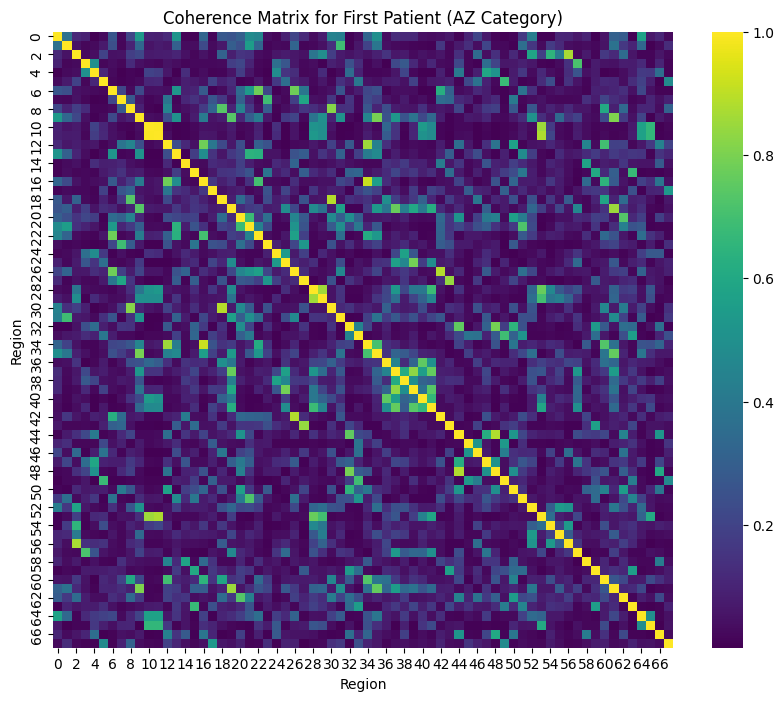

In [ ]:
# Function to visualize a single coherence matrix
def visualize_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=False, cmap='viridis')
    plt.title(title)
    plt.xlabel('Region')
    plt.ylabel('Region')
    plt.show()

# Extract the coherence matrix for the first patient in the AZ category
single_patient_az_matrix = coherence_AZ_rebuilt[:, :, 0, 0]  # Choosing the first frequency band (index 0)

# Visualize the coherence matrix for the first patient in the AZ category
visualize_matrix(single_patient_az_matrix, 'Coherence Matrix for First Patient (AZ Category)')

Extracts edge features from the coherence matrices and assigns labels to them. The function iterates over the subjects and bands, extracting the upper triangular part of each coherence matrix (excluding the diagonal). These edge attributes are then stored in a feature array, and the corresponding labels are stored in a label array




In [ ]:

# Extract edge features and labels
def extract_edge_features_labels(data, label):
    features = []
    labels = []
    for i in range(data.shape[3]):
        for j in range(data.shape[2]):
            matrix = data[:, :, j, i]
            edge_attr = matrix[np.triu_indices_from(matrix, k=1)]
            features.append(edge_attr)
            labels.append(label)
    return np.array(features), np.array(labels)

Use the `extract_edge_features_labels` function to extract features and labels for AZ vs FTD classification


In [ ]:
# Extract features and labels for AZ vs FTD
features_az_ftd, labels_az_ftd = extract_edge_features_labels(coherence_FTD_rebuilt, 1)
features_az_ftd_, labels_az_ftd_ = extract_edge_features_labels(coherence_AZ_rebuilt, 0)
features_az_ftd = np.concatenate((features_az_ftd, features_az_ftd_), axis=0)
labels_az_ftd = np.concatenate((labels_az_ftd, labels_az_ftd_), axis=0)

Split the extracted features and labels into training and testing sets for AZ vs FTD classification


In [ ]:
# Split data into training and testing sets for AZ vs FTD
X_train_az_ftd, X_test_az_ftd, y_train_az_ftd, y_test_az_ftd = train_test_split(features_az_ftd, labels_az_ftd, test_size=0.2, random_state=38)


In [ ]:
def objective_extra_tree(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    extra_tree = ExtraTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    # extra_tree.fit(X_train_az_ftd, y_train_az_ftd)
    # y_pred = extra_tree.predict(X_test_az_ftd)
    # return accuracy_score(y_test_az_ftd, y_pred)
    scores = cross_val_score(extra_tree, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

study_extra_tree = optuna.create_study(direction='maximize')
study_extra_tree.optimize(objective_extra_tree, n_trials=50)

best_params_extra_tree = study_extra_tree.best_params
print("Best parameters for ExtraTreeClassifier (AZ vs FTD):", best_params_extra_tree)

extra_tree = ExtraTreeClassifier(**best_params_extra_tree)
extra_tree.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_extra_tree = extra_tree.predict(X_test_az_ftd)
print("Classification Report for ExtraTreeClassifier (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_extra_tree))
print("Confusion Matrix for ExtraTreeClassifier (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_extra_tree))
print("Accuracy for ExtraTreeClassifier (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_extra_tree))


[I 2024-08-05 08:57:35,222] A new study created in memory with name: no-name-bd583558-4b48-4717-be19-927a80537021
[I 2024-08-05 08:57:35,253] Trial 0 finished with value: 0.53 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.53.
[I 2024-08-05 08:57:35,285] Trial 1 finished with value: 0.52 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.53.
[I 2024-08-05 08:57:35,312] Trial 2 finished with value: 0.4600000000000001 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.53.
[I 2024-08-05 08:57:35,340] Trial 3 finished with value: 0.51 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 

Best parameters for ExtraTreeClassifier (AZ vs FTD): {'criterion': 'gini', 'splitter': 'best', 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 1}
Classification Report for ExtraTreeClassifier (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.75      0.60      0.67         5

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12

Confusion Matrix for ExtraTreeClassifier (AZ vs FTD):
[[6 1]
 [2 3]]
Accuracy for ExtraTreeClassifier (AZ vs FTD): 0.75


In [ ]:
def objective_bagging(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    bootstrap_features = trial.suggest_categorical('bootstrap_features', [True, False])

    bagging = BaggingClassifier(
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        bootstrap=bootstrap,
        bootstrap_features=bootstrap_features
    )
    # bagging.fit(X_train_az_ftd, y_train_az_ftd)
    # y_pred = bagging.predict(X_test_az_ftd)
    # return accuracy_score(y_test_az_ftd, y_pred)
    scores = cross_val_score(bagging, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

study_bagging = optuna.create_study(direction='maximize')
study_bagging.optimize(objective_bagging, n_trials=20)

best_params_bagging = study_bagging.best_params
print("Best parameters for BaggingClassifier (AZ vs FTD):", best_params_bagging)

bagging = BaggingClassifier(**best_params_bagging)
bagging.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_bagging = bagging.predict(X_test_az_ftd)
print("Classification Report for BaggingClassifier (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_bagging))
print("Confusion Matrix for BaggingClassifier (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_bagging))
print("Accuracy for BaggingClassifier (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_bagging))

[I 2024-07-22 09:12:49,324] A new study created in memory with name: no-name-ea3ba386-53bc-4700-86f3-772a3555e145
[I 2024-07-22 09:13:03,507] Trial 0 finished with value: 0.51 and parameters: {'n_estimators': 134, 'max_samples': 0.8074368883424865, 'max_features': 0.6435821785107779, 'bootstrap': True, 'bootstrap_features': False}. Best is trial 0 with value: 0.51.
[I 2024-07-22 09:13:14,207] Trial 1 finished with value: 0.505 and parameters: {'n_estimators': 149, 'max_samples': 0.48450692865076395, 'max_features': 0.6016609235303998, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 0 with value: 0.51.
[I 2024-07-22 09:13:18,938] Trial 2 finished with value: 0.64 and parameters: {'n_estimators': 88, 'max_samples': 0.17640936468259238, 'max_features': 0.9167060562926719, 'bootstrap': False, 'bootstrap_features': False}. Best is trial 2 with value: 0.64.
[I 2024-07-22 09:13:38,379] Trial 3 finished with value: 0.465 and parameters: {'n_estimators': 79, 'max_samples': 0.887

Best parameters for BaggingClassifier (AZ vs FTD): {'n_estimators': 88, 'max_samples': 0.17640936468259238, 'max_features': 0.9167060562926719, 'bootstrap': False, 'bootstrap_features': False}
Classification Report for BaggingClassifier (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

Confusion Matrix for BaggingClassifier (AZ vs FTD):
[[7 0]
 [5 0]]
Accuracy for BaggingClassifier (AZ vs FTD): 0.5833333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameter tuning using Optuna for AdaBoostClassifier (AZ vs HC)
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)

    adaboost = AdaBoostClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    # Train and evaluate using cross-validation
    scores = cross_val_score(adaboost, X_train_az_ftd, y_train_az_ftd, cv=10, scoring='accuracy')
    return scores.mean()

study_adaboost_az_ftd = optuna.create_study(direction='maximize')
study_adaboost_az_ftd.optimize(objective_adaboost, n_trials=20)

best_params_adaboost_az_ftd = study_adaboost_az_ftd.best_params
print("Best parameters for AdaBoostClassifier (AZ vs HC):", best_params_adaboost_az_ftd)

adaboost_az_ftd = AdaBoostClassifier(**best_params_adaboost_az_ftd, random_state=42)
adaboost_az_ftd.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_adaboost = adaboost_az_ftd.predict(X_test_az_ftd)
print("Classification Report for AdaBoostClassifier (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_adaboost))
print("Confusion Matrix for AdaBoostClassifier (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_adaboost))
print("Accuracy for AdaBoostClassifier (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_adaboost))


[I 2024-08-05 07:11:30,929] A new study created in memory with name: no-name-eda7a17d-53e1-44d2-b4a3-c52d26a77f3a
<ipython-input-41-f8acd6df0752>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
[I 2024-08-05 07:12:07,341] Trial 0 finished with value: 0.47000000000000003 and parameters: {'n_estimators': 179, 'learning_rate': 0.03953740047778301}. Best is trial 0 with value: 0.47000000000000003.
<ipython-input-41-f8acd6df0752>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
[I 2024-08-05 07:12:46,925] Trial 1 finished with value: 0.

Best parameters for AdaBoostClassifier (AZ vs HC): {'n_estimators': 146, 'learning_rate': 0.014139064885517229}
Classification Report for AdaBoostClassifier (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

Confusion Matrix for AdaBoostClassifier (AZ vs FTD):
[[7 0]
 [5 0]]
Accuracy for AdaBoostClassifier (AZ vs FTD): 0.5833333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def objective_decision_tree(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    decision_tree = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    decision_tree.fit(X_train_az_ftd, y_train_az_ftd)
    y_pred = decision_tree.predict(X_test_az_ftd)
    return accuracy_score(y_test_az_ftd, y_pred)
    # scores = cross_val_score(decision_tree, X_train_az_ftd, y_train_az_ftd, cv=10)
    # return scores.mean()

study_decision_tree = optuna.create_study(direction='maximize')
study_decision_tree.optimize(objective_decision_tree, n_trials=50)

best_params_decision_tree = study_decision_tree.best_params
print("Best parameters for DecisionTreeClassifier (AZ vs FTD):", best_params_decision_tree)

decision_tree = DecisionTreeClassifier(**best_params_decision_tree)
decision_tree.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_decision_tree = decision_tree.predict(X_test_az_ftd)
print("Classification Report for DecisionTreeClassifier (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_decision_tree))
print("Confusion Matrix for DecisionTreeClassifier (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_decision_tree))
print("Accuracy for DecisionTreeClassifier (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_decision_tree))

[I 2024-08-07 02:55:25,699] A new study created in memory with name: no-name-8a0565e9-699b-486f-a1e3-78cdd4617805
[I 2024-08-07 02:55:25,736] Trial 0 finished with value: 0.75 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.75.
[I 2024-08-07 02:55:25,747] Trial 1 finished with value: 0.4166666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.75.
[I 2024-08-07 02:55:25,765] Trial 2 finished with value: 0.4166666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 29, 'min_samples_split': 16, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.75.
[I 2024-08-07 02:55:25,806] Trial 3 finished with value: 0.6666666666666666 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 17, 'min_samples_le

Best parameters for DecisionTreeClassifier (AZ vs FTD): {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 8}
Classification Report for DecisionTreeClassifier (AZ vs FTD):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.83      1.00      0.91         5

    accuracy                           0.92        12
   macro avg       0.92      0.93      0.92        12
weighted avg       0.93      0.92      0.92        12

Confusion Matrix for DecisionTreeClassifier (AZ vs FTD):
[[6 1]
 [0 5]]
Accuracy for DecisionTreeClassifier (AZ vs FTD): 0.9166666666666666


In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

def objective_svc(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto']) if kernel != 'linear' else 'scale'

    svc = SVC(
        C=C,
        kernel=kernel,
        degree=degree,
        gamma=gamma
    )
    # svc.fit(X_train_az_ftd, y_train_az_ftd)
    # y_pred = svc.predict(X_test_az_ftd)
    # return accuracy_score(y_test_az_ftd, y_pred)
    scores = cross_val_score(svc, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=1000)

best_params_svc = study_svc.best_params
print("Best parameters for SVC (AZ vs FTD):", best_params_svc)

svc = SVC(**best_params_svc)
svc.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_svc = svc.predict(X_test_az_ftd)
print("Classification Report for SVC (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_svc))
print("Confusion Matrix for SVC (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_svc))
print("Accuracy for SVC (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_svc))


[I 2024-08-09 12:29:33,165] A new study created in memory with name: no-name-67e0c632-82c2-4945-a659-d62b7bee5377
<ipython-input-16-d161510bbfac>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2024-08-09 12:29:33,220] Trial 0 finished with value: 0.5449999999999999 and parameters: {'C': 4.655455099406458, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.5449999999999999.
<ipython-input-16-d161510bbfac>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-5, 1e5)
[I 2024-08-09 12:29:33,286] Trial 1 finished with value: 0.59 and parameters: {'C': 14583.701863202128, 'kernel

Best parameters for SVC (AZ vs FTD): {'C': 101.20927832640824, 'kernel': 'sigmoid', 'gamma': 'scale'}
Classification Report for SVC (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12

Confusion Matrix for SVC (AZ vs FTD):
[[6 0]
 [3 3]]
Accuracy for SVC (AZ vs FTD): 0.75


In [ ]:
import optuna
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the objective function for DummyClassifier
def objective_dummy(trial):
    strategy = trial.suggest_categorical('strategy', ['most_frequent', 'stratified', 'uniform'])
    dummy = DummyClassifier(strategy=strategy)

    # Use cross-validation for evaluation
    scores = cross_val_score(dummy, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

# Create and optimize the Optuna study
study_dummy = optuna.create_study(direction='maximize')
study_dummy.optimize(objective_dummy, n_trials=30)  # Fewer trials since DummyClassifier has limited hyperparameters

# Get the best parameters and train the model
best_params_dummy = study_dummy.best_params
print("Best parameters for DummyClassifier (AZ vs FTD):", best_params_dummy)

dummy = DummyClassifier(strategy=best_params_dummy['strategy'])
dummy.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_dummy = dummy.predict(X_test_az_ftd)

# Predict and evaluate the model
print("Classification Report for DummyClassifier (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_dummy))
print("Confusion Matrix for DummyClassifier (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_dummy))
print("Accuracy for DummyClassifier (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_dummy))


[I 2024-08-07 10:18:56,102] A new study created in memory with name: no-name-704431e8-81c2-47d4-8b72-8c4c034435ad
[I 2024-08-07 10:18:56,121] Trial 0 finished with value: 0.6199999999999999 and parameters: {'strategy': 'most_frequent'}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:18:56,137] Trial 1 finished with value: 0.43499999999999994 and parameters: {'strategy': 'uniform'}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:18:56,158] Trial 2 finished with value: 0.5800000000000001 and parameters: {'strategy': 'stratified'}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:18:56,177] Trial 3 finished with value: 0.6199999999999999 and parameters: {'strategy': 'most_frequent'}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:18:56,194] Trial 4 finished with value: 0.495 and parameters: {'strategy': 'stratified'}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:18:56,211] Trial 5 finished with value

Best parameters for DummyClassifier (AZ vs FTD): {'strategy': 'most_frequent'}
Classification Report for DummyClassifier (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.58      1.00      0.74         7
           1       0.00      0.00      0.00         5

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

Confusion Matrix for DummyClassifier (AZ vs FTD):
[[7 0]
 [5 0]]
Accuracy for DummyClassifier (AZ vs FTD): 0.5833333333333334


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import optuna
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the objective function for LabelPropagation
def objective_label_propagation(trial):
    # Choose hyperparameters for LabelPropagation
    kernel = trial.suggest_categorical('kernel', ['knn', 'rbf'])
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1) if kernel == 'rbf' else 1.0
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10) if kernel == 'knn' else 7

    label_propagation = LabelPropagation(kernel=kernel, gamma=gamma, n_neighbors=n_neighbors)

    # Use cross-validation for evaluation
    scores = cross_val_score(label_propagation, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

# Create and optimize the Optuna study
study_label_propagation = optuna.create_study(direction='maximize')
study_label_propagation.optimize(objective_label_propagation, n_trials=30)

# Get the best parameters and train the model
best_params_label_propagation = study_label_propagation.best_params
print("Best parameters for LabelPropagation (AZ vs FTD):", best_params_label_propagation)

label_propagation = LabelPropagation(**best_params_label_propagation)
label_propagation.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_label_propagation = label_propagation.predict(X_test_az_ftd)

# Predict and evaluate the model
print("Classification Report for LabelPropagation (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_label_propagation))
print("Confusion Matrix for LabelPropagation (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_label_propagation))
print("Accuracy for LabelPropagation (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_label_propagation))


[I 2024-08-07 10:19:09,689] A new study created in memory with name: no-name-7da0d10c-0ec1-44df-bec2-09b148ccf19c
<ipython-input-17-b34a6f35f399>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1) if kernel == 'rbf' else 1.0
[I 2024-08-07 10:19:09,746] Trial 0 finished with value: 0.6199999999999999 and parameters: {'kernel': 'rbf', 'gamma': 0.020974601001308775}. Best is trial 0 with value: 0.6199999999999999.
[I 2024-08-07 10:19:09,878] Trial 1 finished with value: 0.6199999999999999 and parameters: {'kernel': 'knn', 'n_neighbors': 4}. Best is trial 0 with value: 0.6199999999999999.
<ipython-input-17-b34a6f35f399>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0

Best parameters for LabelPropagation (AZ vs FTD): {'kernel': 'knn', 'n_neighbors': 5}
Classification Report for LabelPropagation (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.25      0.20      0.22         5

    accuracy                           0.42        12
   macro avg       0.38      0.39      0.38        12
weighted avg       0.40      0.42      0.40        12

Confusion Matrix for LabelPropagation (AZ vs FTD):
[[4 3]
 [4 1]]
Accuracy for LabelPropagation (AZ vs FTD): 0.4166666666666667


In [ ]:
import optuna
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the objective function for LabelSpreading
def objective_label_spreading(trial):
    # Choose hyperparameters for LabelSpreading
    kernel = trial.suggest_categorical('kernel', ['knn', 'rbf'])
    gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1) if kernel == 'rbf' else 1.0
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10) if kernel == 'knn' else 7

    label_spreading = LabelSpreading(kernel=kernel, gamma=gamma, n_neighbors=n_neighbors)

    # Use cross-validation for evaluation
    scores = cross_val_score(label_spreading, X_train_az_ftd, y_train_az_ftd, cv=10)
    return scores.mean()

# Create and optimize the Optuna study
study_label_spreading = optuna.create_study(direction='maximize')
study_label_spreading.optimize(objective_label_spreading, n_trials=30)

# Get the best parameters and train the model
best_params_label_spreading = study_label_spreading.best_params
print("Best parameters for LabelSpreading (AZ vs FTD):", best_params_label_spreading)

label_spreading = LabelSpreading(**best_params_label_spreading)
label_spreading.fit(X_train_az_ftd, y_train_az_ftd)
y_pred_label_spreading = label_spreading.predict(X_test_az_ftd)

# Predict and evaluate the model
print("Classification Report for LabelSpreading (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred_label_spreading))
print("Confusion Matrix for LabelSpreading (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred_label_spreading))
print("Accuracy for LabelSpreading (AZ vs FTD):", accuracy_score(y_test_az_ftd, y_pred_label_spreading))


[I 2024-08-07 10:19:27,936] A new study created in memory with name: no-name-5f8b85c6-80fc-486d-b914-60ee7447beea
[I 2024-08-07 10:19:27,996] Trial 0 finished with value: 0.625 and parameters: {'kernel': 'knn', 'n_neighbors': 8}. Best is trial 0 with value: 0.625.
[I 2024-08-07 10:19:28,060] Trial 1 finished with value: 0.625 and parameters: {'kernel': 'knn', 'n_neighbors': 6}. Best is trial 0 with value: 0.625.
[I 2024-08-07 10:19:28,113] Trial 2 finished with value: 0.65 and parameters: {'kernel': 'knn', 'n_neighbors': 7}. Best is trial 2 with value: 0.65.
<ipython-input-18-f17c7b8eec6d>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e1) if kernel == 'rbf' else 1.0
[I 2024-08-07 10:19:28,180] Trial 3 finished with value: 0.595 and parameters: {'kernel': 'rbf', 'gamma': 0.199

Best parameters for LabelSpreading (AZ vs FTD): {'kernel': 'knn', 'n_neighbors': 5}
Classification Report for LabelSpreading (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.25      0.20      0.22         5

    accuracy                           0.42        12
   macro avg       0.38      0.39      0.38        12
weighted avg       0.40      0.42      0.40        12

Confusion Matrix for LabelSpreading (AZ vs FTD):
[[4 3]
 [4 1]]
Accuracy for LabelSpreading (AZ vs FTD): 0.4166666666666667


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the best parameters for each model
best_params = {
    'ExtraTreesClassifier': {'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 9, 'min_samples_leaf': 1},
    'BaggingClassifier': {'n_estimators': 88, 'max_samples': 0.17640936468259238, 'max_features': 0.9167060562926719, 'bootstrap': False, 'bootstrap_features': False},
    'DecisionTreeClassifier': {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 15, 'min_samples_leaf': 8},
    'AdaBoostClassifier': {'n_estimators': 146, 'learning_rate': 0.014139064885517229},
    'SVC': {'C': 218.092808835883, 'kernel': 'sigmoid', 'gamma': 'scale'},
    #'SVC': {'C': 0.001109635495830659, 'kernel': 'poly', 'degree': 3, 'gamma': 'auto'},
    'DummyClassifier': {'strategy': 'most_frequent'},
    'LabelPropagation': {'kernel': 'knn', 'n_neighbors': 5},
    'LabelSpreading': {'kernel': 'knn', 'n_neighbors': 5}
}
# {'C': 218.092808835883, 'kernel': 'sigmoid', 'gamma': 'scale'}
# {'C': 101.20927832640824, 'kernel': 'sigmoid', 'gamma': 'scale'}

# Initialize the classifiers with the best parameters
classifiers = {
    'ExtraTreesClassifier': ExtraTreesClassifier(**best_params['ExtraTreesClassifier']),
    'BaggingClassifier': BaggingClassifier(**best_params['BaggingClassifier']),
    'DecisionTreeClassifier': DecisionTreeClassifier(**best_params['DecisionTreeClassifier']),
    'AdaBoostClassifier': AdaBoostClassifier(**best_params['AdaBoostClassifier']),
    'SVC': SVC(**best_params['SVC']),
    'DummyClassifier': DummyClassifier(**best_params['DummyClassifier']),
    'LabelPropagation': LabelPropagation(**best_params['LabelPropagation']),
    'LabelSpreading': LabelSpreading(**best_params['LabelSpreading'])
}

# Perform cross-validation and store the results
cv_results = {}

for name, clf in classifiers.items():
    scores = cross_val_score(clf, X_train_az_ftd, y_train_az_ftd, cv=10)
    cv_results[name] = scores

# Print summary of cross-validation results
print("\nSummary of cross-validation results (AZ vs FTD):")
for name, scores in cv_results.items():
    print(f"{name}: Mean accuracy = {scores.mean():.4f}, Standard deviation = {scores.std():.4f}")

# Choose the best model based on mean cross-validation accuracy
best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f"\nBest model based on cross-validation (AZ vs FTD): {best_model_name}")

# Evaluate the best model on the test set
best_model = classifiers[best_model_name]
best_model.fit(X_train_az_ftd, y_train_az_ftd)
y_pred = best_model.predict(X_test_az_ftd)

print(f"\nClassification Report for {best_model_name} (AZ vs FTD):")
print(classification_report(y_test_az_ftd, y_pred))
print(f"Confusion Matrix for {best_model_name} (AZ vs FTD):")
print(confusion_matrix(y_test_az_ftd, y_pred))
print(f"Accuracy for {best_model_name} (AZ vs FTD): {accuracy_score(y_test_az_ftd, y_pred):.4f}")



Summary of cross-validation results (AZ vs FTD):
ExtraTreesClassifier: Mean accuracy = 0.5800, Standard deviation = 0.1145
BaggingClassifier: Mean accuracy = 0.6450, Standard deviation = 0.0687
DecisionTreeClassifier: Mean accuracy = 0.5050, Standard deviation = 0.2150
AdaBoostClassifier: Mean accuracy = 0.5100, Standard deviation = 0.0831
SVC: Mean accuracy = 0.6800, Standard deviation = 0.1990
DummyClassifier: Mean accuracy = 0.6450, Standard deviation = 0.0687
LabelPropagation: Mean accuracy = 0.5600, Standard deviation = 0.1261
LabelSpreading: Mean accuracy = 0.5600, Standard deviation = 0.1261

Best model based on cross-validation (AZ vs FTD): SVC

Classification Report for SVC (AZ vs FTD):
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         6
           1       1.00      0.33      0.50         6

    accuracy                           0.67        12
   macro avg       0.80      0.67      0.62        12
weighted avg       0.8

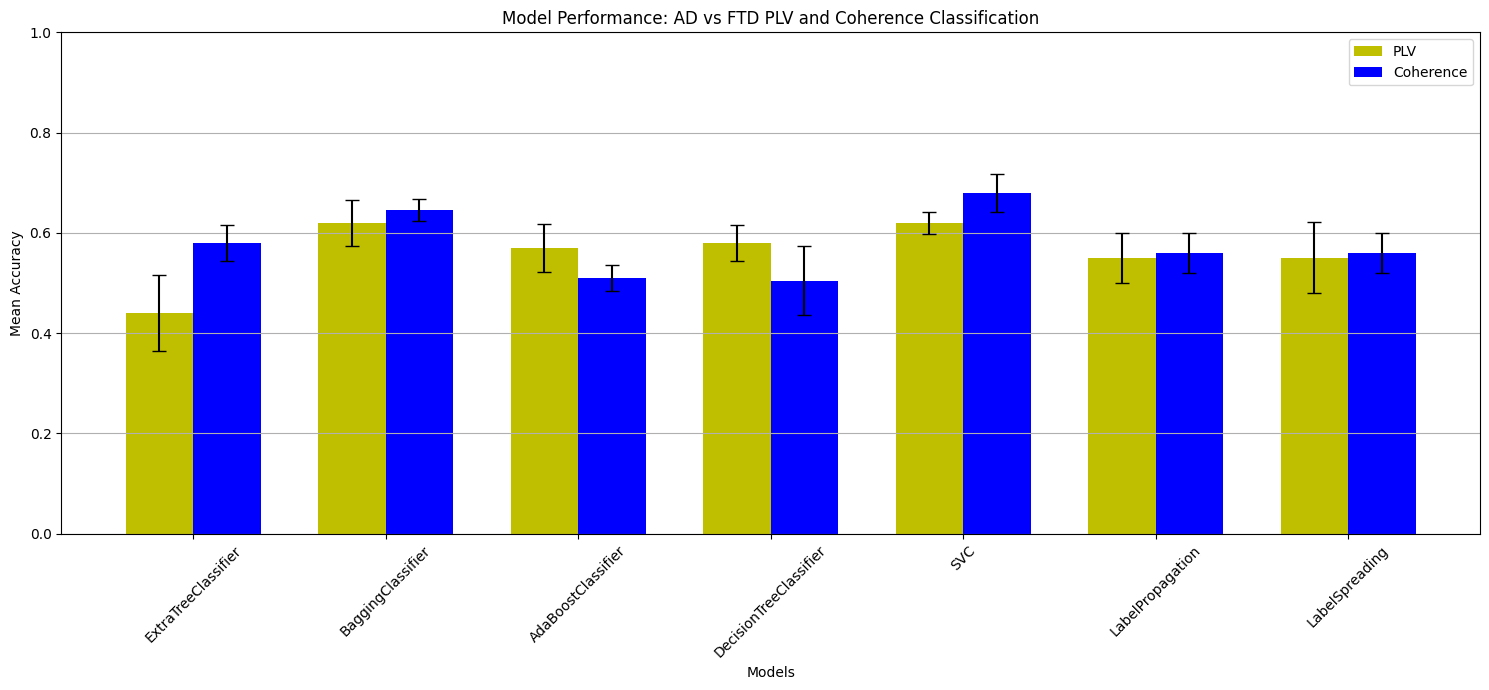

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ordered models (same as previous examples)
models = ['ExtraTreeClassifier', 'BaggingClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier',
          'SVC', 'LabelPropagation', 'LabelSpreading']

# Data for AZ vs FTD PLV classification (updated)
mean_acc_plv = [0.4400, 0.6200, 0.5700, 0.5800, 0.6200,
                0.5500, 0.5500]
std_dev_plv = [0.2385, 0.1453, 0.1503, 0.1145, 0.0714,
                0.1581, 0.2236]

# Data for AZ vs FTD Coherence classification (updated)
mean_acc_coherence = [0.5800, 0.6450, 0.5100, 0.5050, 0.6800,
                       0.5600, 0.5600]
std_dev_coherence = [0.1145, 0.0687, 0.0831, 0.2150, 0.1190,
                      0.1261, 0.1261]

# Calculate standard error
n = 10
std_err_plv = [std / np.sqrt(n) for std in std_dev_plv]
std_err_coherence = [std / np.sqrt(n) for std in std_dev_coherence]

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Bar plots
bars_plv = ax.bar(index - bar_width/2, mean_acc_plv, bar_width, yerr=std_err_plv, capsize=5, label='PLV', color='y')
bars_coherence = ax.bar(index + bar_width/2, mean_acc_coherence, bar_width, yerr=std_err_coherence, capsize=5, label='Coherence', color='b')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Model Performance: AD vs FTD PLV and Coherence Classification')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend()

ax.set_ylim(0, 1)
# Add grid
ax.yaxis.grid(True)

# Show plot
plt.tight_layout()
plt.show()


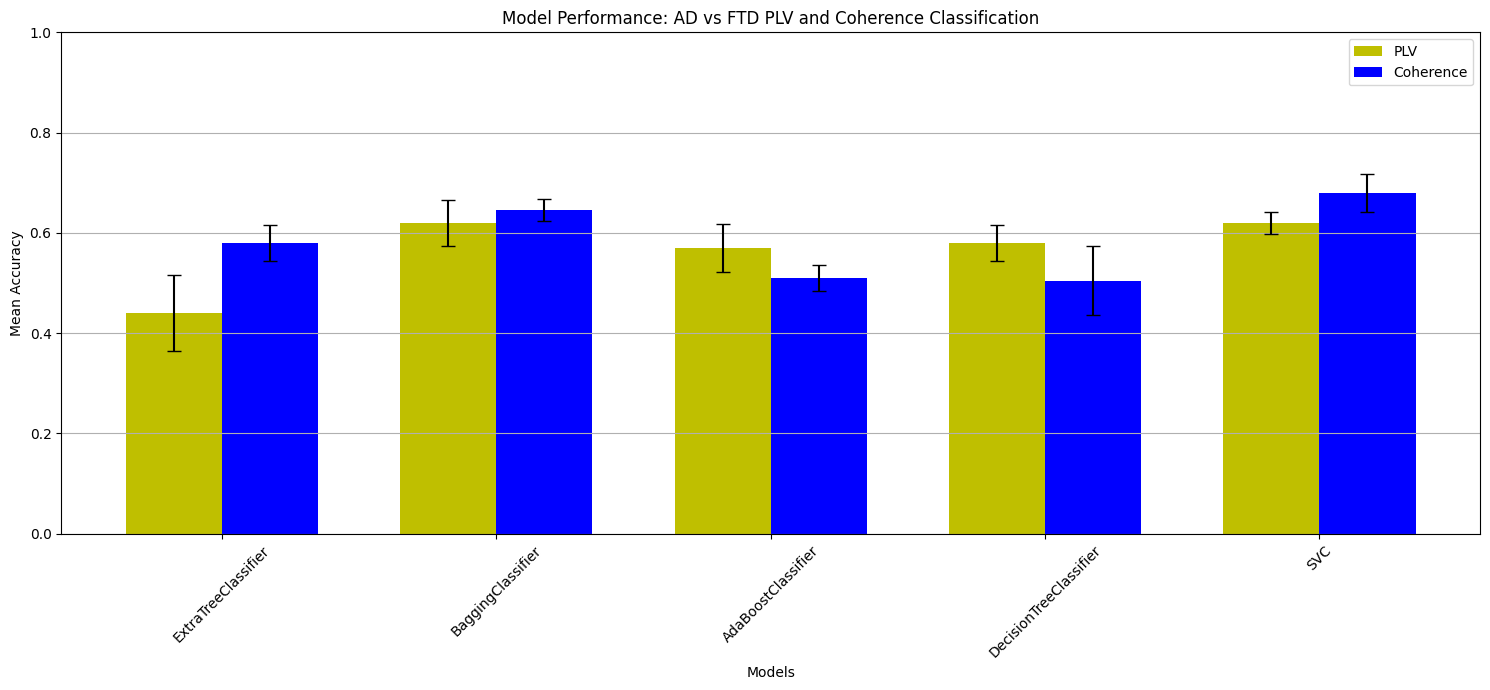

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Ordered models (same as previous examples)
models = ['ExtraTreeClassifier', 'BaggingClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier',
          'SVC']

# Data for AZ vs FTD PLV classification (updated)
mean_acc_plv = [0.4400, 0.6200, 0.5700, 0.5800, 0.6200]
std_dev_plv = [0.2385, 0.1453, 0.1503, 0.1145, 0.0714]

# Data for AZ vs FTD Coherence classification (updated)
mean_acc_coherence = [0.5800, 0.6450, 0.5100, 0.5050, 0.6800]
std_dev_coherence = [0.1145, 0.0687, 0.0831, 0.2150, 0.1190]

# Calculate standard error
n = 10
std_err_plv = [std / np.sqrt(n) for std in std_dev_plv]
std_err_coherence = [std / np.sqrt(n) for std in std_dev_coherence]

# Plotting
fig, ax = plt.subplots(figsize=(15, 7))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(models))

# Bar plots
bars_plv = ax.bar(index - bar_width/2, mean_acc_plv, bar_width, yerr=std_err_plv, capsize=5, label='PLV', color='y')
bars_coherence = ax.bar(index + bar_width/2, mean_acc_coherence, bar_width, yerr=std_err_coherence, capsize=5, label='Coherence', color='b')

# Labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Model Performance: AD vs FTD PLV and Coherence Classification')
ax.set_xticks(index)
ax.set_xticklabels(models, rotation=45)
ax.legend()

ax.set_ylim(0, 1)
# Add grid
ax.yaxis.grid(True)

# Show plot
plt.tight_layout()
plt.show()
